In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("./Cricket Dataset.csv")

C:\Users\debdi\AppData\Local\Temp\ipykernel_60324\3141108476.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Cricket Dataset.csv")


In [4]:
df.head()

,Balls,MatchNo,Innings,BattingTeam,City,Date,Match_Type,Toss_Decision,Toss_Winner,Venue,...,Temp,Score,Wickets,Wicket_ball,Ext_bl,fsdasfasd,Ball_b,Wicket_kind,Wicket_Fielders,Player_out
0,1,1,1,Australia,London,9/4/2009,ODI,field,England,Kennington Oval,...,1,1,0,0,1,0,1,NaN,NaN,NaN
1,2,1,1,Australia,London,9/4/2009,ODI,field,England,Kennington Oval,...,1,1,0,0,1,1,1,NaN,NaN,NaN
2,3,1,1,Australia,London,9/4/2009,ODI,field,England,Kennington Oval,...,1,1,0,0,1,2,2,NaN,NaN,NaN
3,4,1,1,Australia,London,9/4/2009,ODI,field,England,Kennington Oval,...,1,1,0,0,1,3,3,NaN,NaN,NaN
4,5,1,1,Australia,London,9/4/2009,ODI,field,England,Kennington Oval,...,1,5,0,0,1,4,4,NaN,NaN,NaN


In [5]:
selected_columns = df.columns[[1,2,13,22,24,25,26,29]]
selected_columns

Index(['MatchNo', 'Innings', 'Over', 'Runs_Total', 'Score', 'Wickets',
       'Wicket_ball', 'Ball_b'],
      dtype='object')

### Description of Selected Columns

- **MatchNo**: The unique number assigned to the match.  
- **Innings**: Indicates whether the data corresponds to the 1st or 2nd innings (values: 1 or 2).  
- **Over**: Represents the current over in the match, formatted as `x.y` (e.g., `0.1`, `0.5`, `3.6`), where `x` is the over count and `y` is the ball number within the over.  
- **Runs_Total**: The total runs scored on that particular ball, including extras.  
- **Score**: The cumulative score of the batting team at that point in the match.  
- **Wickets**: The total number of wickets lost by the batting team so far.  
- **Wicket_ball**: A binary field (`0` or `1`) indicating whether the given ball resulted in a wicket (`1` if a wicket fell, `0` otherwise).  
- **Ball_b**: The sequential ball number in the match (e.g., in an ODI, it will be at least 300 or more if there are extra deliveries due to no-balls or wides).  

In [59]:
data = df[selected_columns]
data = data[data["Innings"] == 2]

In [60]:
data.head()

,MatchNo,Innings,Over,Runs_Total,Score,Wickets,Wicket_ball,Ball_b
304,1,2,0.1,0,0,0,0,1
305,1,2,0.2,0,0,0,0,2
306,1,2,0.3,0,0,0,0,3
307,1,2,0.4,0,0,0,0,4
308,1,2,0.5,2,2,0,0,5


### Calculating P(b, w) which represents the probability of a wicket falling at a specific ball b when w wickets have already fallen.

In [66]:
pbw = np.zeros((300, 11))
sum_prob_wicket = np.zeros((300, 11))
count = np.zeros((300, 11))

for i in range(len(data) - 1):
    balls = int(data.iloc[i]["Ball_b"])
    wickets = int(data.iloc[i]["Wickets"])
    wicket_ball = int(data.iloc[i]["Wicket_ball"])
    
    if 1 <= balls <= 300 and 0 <= wickets <= 10:
        sum_prob_wicket[balls - 1, wickets] += wicket_ball
        count[balls - 1, wickets] += 1 
        
for i in range(300):
    for j in range(11):
        if count[i, j] > 0:
            pbw[i, j] = sum_prob_wicket[i, j] / count[i, j]
        elif j == 0 and i > 0:  # Use data from wickets=1 when wickets=0 has no valid probability
            pbw[i, j] = pbw[i, 1]

### Calculating q(r, b, w) which represents the probability of scoring r runs at a specific ball b when w wickets have fallen

##### Assuming that in cricket, the valid runs are 0, 1, 2, 3, 4, 6

In [67]:
qrbw = np.zeros((6, 300, 11))
count = np.zeros((300, 11))
sum_run_prob = np.zeros((6, 300, 11))

run_values = [0, 1, 2, 3, 4, 6]
run_index_map = {r: i for i, r in enumerate(run_values)}

for i in range(len(data)):
    balls = int(data.iloc[i]["Ball_b"])
    wickets = int(data.iloc[i]["Wickets"])
    runs = int(data.iloc[i]["Runs_Total"])
    
    if 1 <= balls <= 300 and 1 <= wickets <= 10 and runs in run_index_map:
        sum_run_prob[run_index_map[runs], balls - 1, wickets] += 1
        count[balls - 1, wickets] += 1

for r_idx in range(6):
    for i in range(300):
        for j in range(11):
            if count[i, j] > 0:
                qrbw[r_idx, i, j] = sum_run_prob[r_idx, i, j] / count[i, j]

In [69]:
qrbw[:, 99, 3]

array([0.49166667, 0.36666667, 0.04166667, 0.00833333, 0.08333333,
       0.00833333])

# Understanding the Formula for \( P(r, b, w) \)

We aim to compute \( P(r, b, w) \), which represents the probability of successfully chasing **r** runs when **b** balls have been bowled and **w** wickets have fallen. This is a crucial aspect of cricket analytics, helping to model match outcomes based on different game states.

## Formula Breakdown  

The probability of winning at any given state **(r, b, w)** is determined by considering:  
1. **The probability of losing a wicket on the next ball**  
2. **The probability of scoring runs (0, 1, 2, 3, 4, or 6) on the next ball**  
3. **The probability of winning based on the updated game state**  

We define:  
- **\( P(r, b, w) \)**: Probability of winning when **r** runs are required, **b** balls have been bowled, and **w** wickets have fallen.  
- **\( p(b, w) \)**: Probability of losing a wicket on ball **b+1** when **w** wickets have fallen.  
- **\( q(r, b, w) \)**: Probability of scoring **r** runs on ball **b+1** when **w** wickets have fallen.

Using this, we can express \( P(r, b, w) \) recursively as:

\[
P(r, b, w) = P(r, b+1, w+1) q(0, b, w) p(b, w) + P(r, b+1, w) q(0, b, w) (1 - p(b, w))
\]

\[
+ P(r-1, b+1, w) q(1, b, w) + P(r-2, b+1, w) q(2, b, w) + P(r-3, b+1, w) q(3, b, w)
\]

\[
+ P(r-4, b+1, w) q(4, b, w) + P(r-6, b+1, w) q(6, b, w)
\]

## Explanation  

- The first term considers the scenario where a **wicket is lost**.  
- The second term accounts for **not losing a wicket and scoring 0 runs**.  
- The remaining terms represent scoring 1, 2, 3, 4, or 6 runs and transitioning to the next state accordingly.

This dynamic programming approach allows us to efficiently compute \( P(r, b, w) \) for all possible game states.

---


In [70]:
max_runs = 400  # Max target runs (adjustable)
max_balls = 300
max_wickets = 10

P = np.zeros((max_runs + 1, max_balls + 1, max_wickets + 1))

P[0, :, :] = 1  # If no runs are required, the team has already won

for i in range(1, max_runs + 1):
    for j in range(max_balls - 1, -1, -1):
        for k in range(max_wickets - 1, -1, -1):
            
            P[i, j, k] += P[i, j + 1, k + 1] * qrbw[0, j, k] * pbw[j, k] # Wicket loss
            P[i, j, k] += P[i, j + 1, k] * qrbw[0, j, k] * (1 - pbw[j, k]) # No wicket loss
            
            for idx in range(1, len(run_values)):  # Skip 0 since it's handled separately
                run_scored = run_values[idx]
                if i - run_scored >= 0:
                    P[i, j, k] += P[i - run_scored, j + 1, k] * qrbw[run_index_map[run_scored], j, k]

## Testing

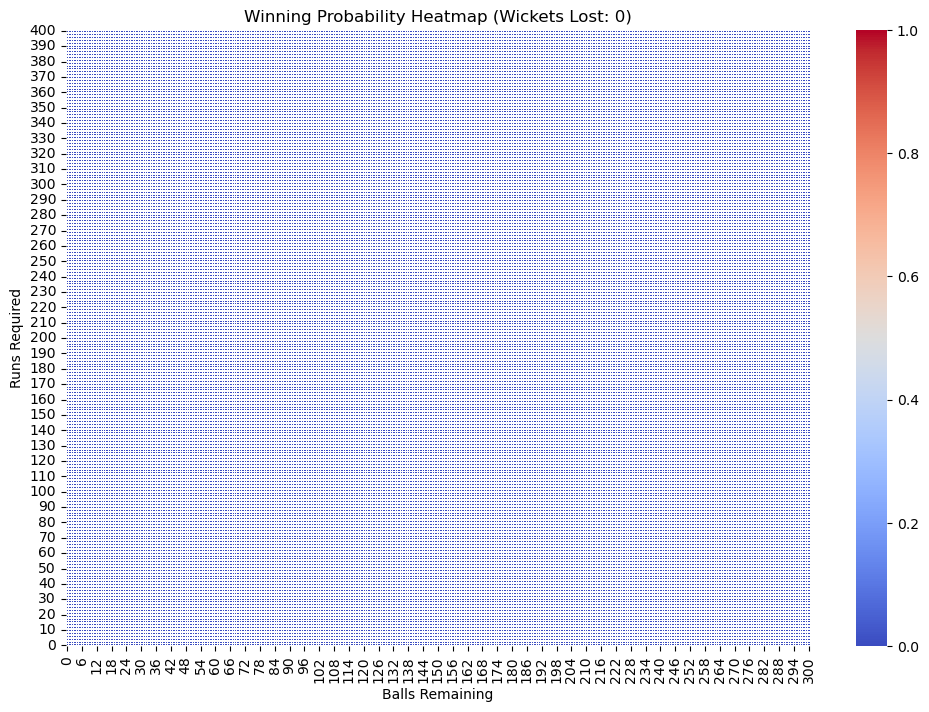

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a fixed number of wickets lost (e.g., w = 3)
wickets_lost = 0

# Extract P(r, b, w) for w = 3
heatmap_data = P[:, :, wickets_lost]

# Plot heatmap for P(r, b, w)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", linewidths=0.5)
plt.xlabel("Balls Remaining")
plt.ylabel("Runs Required")
plt.title(f"Winning Probability Heatmap (Wickets Lost: {wickets_lost})")
plt.gca().invert_yaxis()  # Invert Y-axis so 0 runs is at the top
plt.show()